In [569]:
import pandas as pd
import re
import matplotlib.pyplot as plt


In [570]:
def clean_numeric(text):
    if isinstance(text, str):
        return re.sub(r'[^0-9.]', '', text)
    return text


In [571]:
def clean_text(text):
    if isinstance(text, str):
        # Mantener letras, números, espacios y tildes
        # Eliminar saltos de línea
        text = re.sub(r'\n', '', text)
        return re.sub(r'[^A-Za-z0-9\sÁÉÍÓÚáéíóúñÑ]', '', text).strip()
    return text


In [572]:
def clean_date(text):
    if isinstance(text, str):
        # Eliminar caracteres que no sean números o guiones
        text = re.sub(r'[^0-9-]', '', text) 
    return text


In [573]:
def clean_email(text):
    if isinstance(text, str):
        # Reemplazar caracteres especiales en medio con '@'
        text = re.sub(r'[^A-Za-z0-9@._-]', '@', text)
        
        # Eliminar caracteres especiales de los extremos
        text = re.sub(r'^[^A-Za-z0-9]+|[^A-Za-z0-9]+$', '', text)
        
        # Asegurarse de que solo haya una '@'
        parts = text.split('@')
        if len(parts) > 2:
            text = parts[0] + '@' + ''.join(parts[1:])
        elif len(parts) == 2:
            text = parts[0] + '@' + parts[1]

        # Eliminar caracteres especiales después del '@' excepto para '.' y '-'
        if '@' in text:
            local, domain = text.split('@', 1)
            domain = re.sub(r'[^A-Za-z0-9.-]', '', domain)
            text = f'{local}@{domain}'

        return text
    return text

In [574]:
def clean_phone(numero):
    # Eliminar caracteres especiales excepto números
    numero = re.sub(r'\D', '', numero)
    
    # Quitar los '0' a la izquierda si los hay
    numero = numero.lstrip('0')
    
    # Agregar '1' al principio si hay exactamente 10 números
    if len(numero) == 10:
        numero = '1' + numero
        
    # Agregar '1' al principio si no lo tiene
    if not numero.startswith('1'):
        numero = '1' + numero
    
    # Formatear el número y extraer la extensión si existe
    if len(numero) > 11:  # Si hay más de 11 dígitos, hay una extensión
        formateado = f'+{numero[0]} ({numero[1:4]}) {numero[4:7]}-{numero[7:11]}'
        extension = numero[11:]
    else:
        formateado = f'+{numero[0]} ({numero[1:4]}) {numero[4:7]}-{numero[7:11]}'
        extension = ''
    
    return formateado, extension

In [575]:
def clean_text_advanced(text):
    if isinstance(text, str):
        # Reemplazar caracteres especiales por espacio, excepto letras, números y espacios
        text = re.sub(r'[^A-Za-z0-9ÁÉÍÓÚáéíóúñÑ\s]', ' ', text)
        
        # Reemplazar múltiples espacios por un solo espacio
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text.strip()  # Eliminar espacios en blanco al principio y al final
    return text

In [576]:
df=pd.read_csv(r'./files/datos_ventas.csv',delimiter=",",encoding="ISO-8859-1")

In [577]:
df['ID_Venta']=df['ID_Venta'].apply(clean_numeric)
df['Producto'] = df['Producto'].apply(clean_text)
df['Ciudad'] = df['Ciudad'].apply(clean_text_advanced)
df['Categoria'] = df['Categoria'].apply(clean_text)
df['Precio_Unitario'] = df['Precio_Unitario'].apply(clean_numeric)
df['Cantidad'] = df['Cantidad'].apply(clean_numeric)
df['Fecha_Venta'] = df['Fecha_Venta'].apply(clean_date)
df['Cliente'] = df['Cliente'].apply(clean_text_advanced)
df['Email'] = df['Email'].apply(clean_email)
df[['Telefono', 'Extension']] = df['Telefono'].apply(lambda x: pd.Series(clean_phone(x)))
df['Direccion'] = df['Direccion'].apply(clean_text_advanced)
df['Metodo_Pago'] = df['Metodo_Pago'].apply(clean_text)
df['Estado'] = df['Estado'].apply(clean_text_advanced)
df['Comentario'] = df['Comentario'].apply(clean_text_advanced)
df['Descuento'] = df['Descuento'].apply(clean_numeric)

In [578]:
columns = list(df.columns)
telefono_idx = columns.index('Telefono')
columns.insert(telefono_idx + 1, columns.pop(columns.index('Extension')))
df = df[columns]

In [579]:
output_path = './files/archivo_limpio.xlsx'

In [580]:
df.to_excel(output_path, index=False)

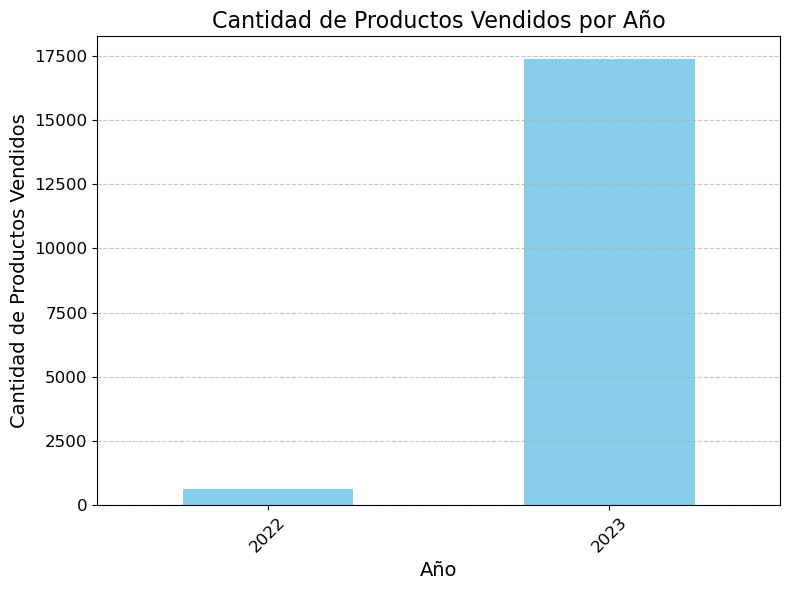

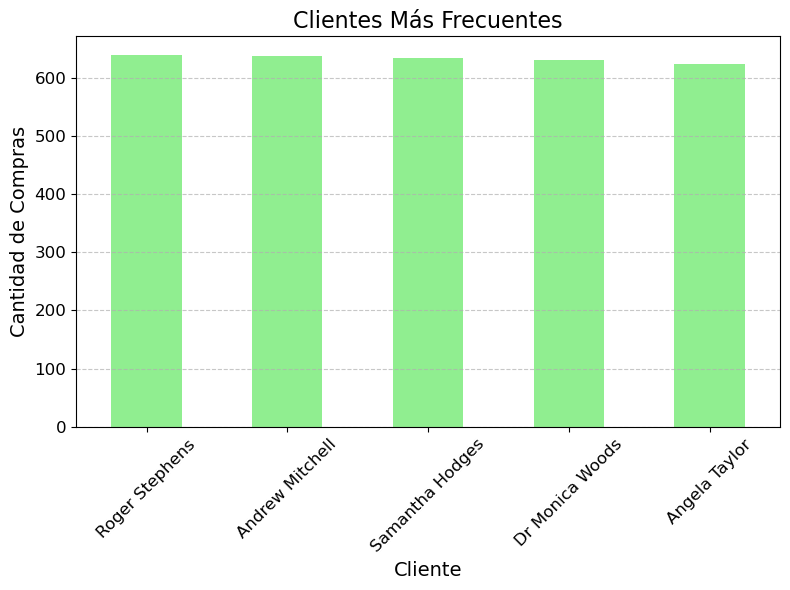

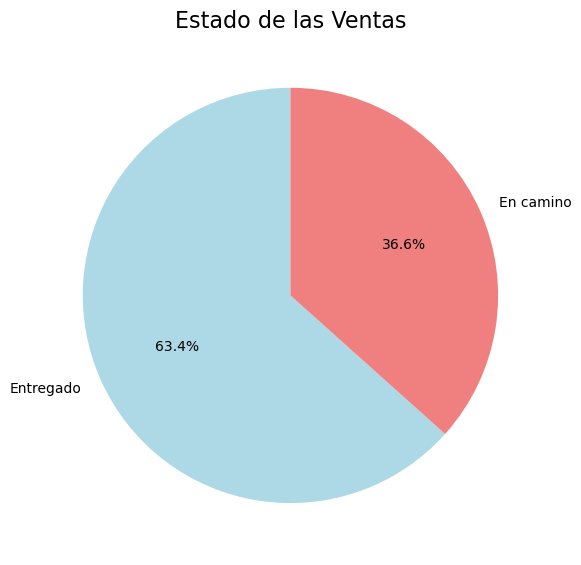

In [581]:
# Convertir la columna 'Fecha_Venta' a tipo datetime
df['Fecha_Venta'] = pd.to_datetime(df['Fecha_Venta'])

# Gráfico 1: Cantidad de productos vendidos por año
# Agrupar por año y contar la cantidad de ventas
ventas_por_anio = df.groupby(df['Fecha_Venta'].dt.year)['ID_Venta'].count()

plt.figure(figsize=(8, 6))
ventas_por_anio.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Productos Vendidos por Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Cantidad de Productos Vendidos', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico 2: Clientes más frecuentes
# Contar las ventas por cliente y ordenar de mayor a menor
clientes_frecuentes = df['Cliente'].value_counts().nlargest(5)  # Obtener los 5 clientes más frecuentes

plt.figure(figsize=(8, 6))
clientes_frecuentes.plot(kind='bar', color='lightgreen')
plt.title('Clientes Más Frecuentes', fontsize=16)
plt.xlabel('Cliente', fontsize=14)
plt.ylabel('Cantidad de Compras', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico 3: Estado de las ventas (entregadas y en camino)
# Contar las ventas por estado
ventas_por_estado = df['Estado'].value_counts()

plt.figure(figsize=(6, 6))
ventas_por_estado.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Estado de las Ventas', fontsize=16)
plt.ylabel('')
plt.tight_layout()
plt.show()